In [77]:
import glob
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import cv2
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from itertools import chain 
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [2]:
folders= ['daisy','dandelion','rose','sunflower','tulip']

In [3]:
transform_image = transforms.Compose([
       #  transforms.RandomRotation(10),      # rotate +/- 10 degrees
       #  transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
                                    ])

In [4]:
dataset=ImageFolder('./data/flowers',transform=transform_image)

In [5]:
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=40)

In [6]:
# Train and Test DataLoader
train_loader = DataLoader(dataset = train_data , batch_size = 10 ,shuffle=True)
test_loader = DataLoader(dataset = test_data , batch_size = 10 ,shuffle=True)

In [7]:
# Detect if we have a GPU available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def imshow(input, labels):
    batchs = input.shape[0]
    # fig,ax = plt.subplots(1,batchs)
    fig = plt.figure(figsize= (15,9))
    for i in range(batchs):
        ax= fig.add_subplot(2, int(batchs/2) , i+1, xticks=[], yticks=[])
        mean = [-0.485/0.229,-0.456/0.224,-0.406/0.225]
        std = [1/0.229,1/0.224,1/0.225]
        nrm = transforms.Normalize(mean= mean, std= std)
        image= nrm(input)
        image = image[i,:,:,:].detach().numpy().transpose((1,2,0))
        ax.imshow(image) 
        # ax.set_title(labels[i], color='gray', fontsize=20)
        ax.set_title("Label: {0}".format(dataset.classes[labels[i]]), color='gray', fontsize=15)
        
    plt.show()

In [9]:
images, labels= next(iter(train_loader))

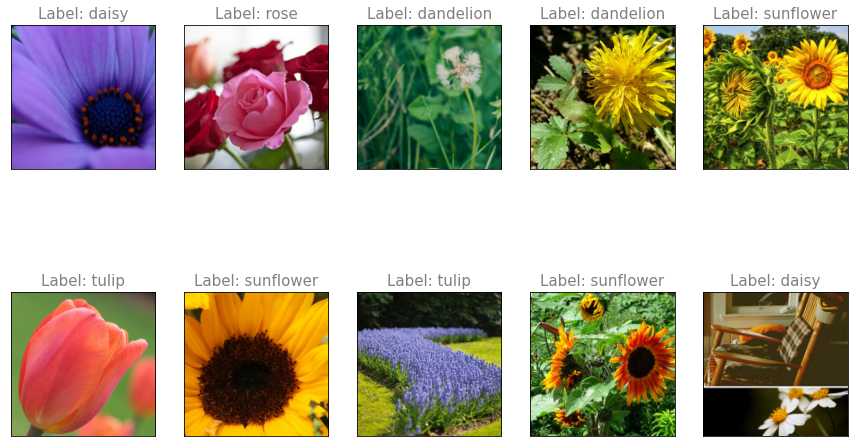

In [10]:
imshow(images,labels)

#### Model:

In [61]:
alex_net = models.alexnet(weights="AlexNet_Weights.DEFAULT")
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [62]:
alex_net = alex_net.to(device)

#### Freeze layers:

In [63]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [64]:
set_parameter_requires_grad(alex_net, True)

#### Reshape Layers:

In [65]:
#reshape last fully connected layer
num_ftrs = alex_net.classifier[6].in_features
alex_net.classifier[6] = nn.Linear(num_ftrs, len(dataset.classes))

In [66]:
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Loss Function:

In [67]:
loss_fn = nn.CrossEntropyLoss()

#### Parameters to Learn:

In [68]:

print("Params to learn:")
params_to_update = []
for name,param in alex_net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


#### Optimizer:

In [69]:
optimizer1 = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [70]:
# lr= 1e-4
optimizer2 = optim.Adam(params_to_update, lr=0.001)

#### Training Model:

In [71]:
alex_net.to(device)
epochs = 60

loss_train_list,loss_test_list = [] , []
train_accuracy_list, test_accuracy_list = [], []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

###################################    Training     ##########################################
for epoch in range(1, epochs+1):
    total_train, total_test = 0 , 0
    correct_train, correct_test = 0 , 0


    sum_of_loss_train = 0
    alex_net.train()
    # Loop for train batches
    loop_train = tqdm(enumerate(train_loader, 1),total=len(train_loader), desc="train")
    for i,(inputs, labels) in loop_train:
        # print(inputs)
        # print(labels)
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alex_net(inputs)
        loss = loss_fn(outputs, labels)
        optimizer1.zero_grad()
        # print('**********', loss)
        loss.backward()
        optimizer1.step()
        #calculate loss of train data
        sum_of_loss_train += loss.item()
        loop_train.set_description(f'Train - epoch : {epoch}')
        loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
        loop_train.refresh()
        #calculate accuracy of train data
        predictions_train = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions_train == labels).sum()
        total_train += len(labels)
        
    train_accuracy = correct_train * 100 / total_train   
    train_accuracy_list.append(train_accuracy.cpu()) 
                
    loss_train_list.append((sum_of_loss_train/i))

    alex_net.to(device)
    ################################    Testing by validation data    ##############################################
    alex_net.eval()
    with torch.no_grad():
    # Loop for test batches
        loop_test = tqdm(enumerate(test_loader, 1),total=len(test_loader), desc="val")
        sum_of_loss_test = 0
        for i,(inputs, labels) in loop_test:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_list.append(labels)
            outputs = alex_net(inputs)
            #calculate loss of test data
            curr_loss_test = loss_fn(outputs, labels)
            sum_of_loss_test += curr_loss_test.item()
            loop_test.set_description(f'Test - epoch : {epoch}')
            loop_test.set_postfix(curr_loss_test = {sum_of_loss_test/i})   
            loop_test.refresh()
            #calculate accuracy of test data
            predictions_test = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions_test)
            correct_test += (predictions_test == labels).sum()
            total_test += len(labels)
            
        test_accuracy = correct_test * 100 / total_test
        test_accuracy_list.append(test_accuracy.cpu())             
        
        loss_test_list.append((sum_of_loss_test/i))
            
        print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list[-1]} , Train Accuracy= {train_accuracy:.3f} %')
        print(f'At Epoch {epoch}/{epochs}: Test Loss= {loss_test_list[-1]} , Test Accuracy= {test_accuracy:.3f} %')
        print()

train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 1/60:  Train Loss= 0.8100467074630147 , Train Accuracy= 78.048 %
At Epoch 1/60: Test Loss= 0.9780684571760712 , Test Accuracy= 78.125 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 2/60:  Train Loss= 0.5897653245138653 , Train Accuracy= 85.259 %
At Epoch 2/60: Test Loss= 0.6185861481340259 , Test Accuracy= 85.417 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 3/60:  Train Loss= 0.43690130610062794 , Train Accuracy= 88.213 %
At Epoch 3/60: Test Loss= 0.6913297885658231 , Test Accuracy= 82.176 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 4/60:  Train Loss= 0.3938161004525419 , Train Accuracy= 89.227 %
At Epoch 4/60: Test Loss= 0.64817148699755 , Test Accuracy= 85.648 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 5/60:  Train Loss= 0.3382055932859321 , Train Accuracy= 90.820 %
At Epoch 5/60: Test Loss= 0.6835052642935149 , Test Accuracy= 84.838 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 6/60:  Train Loss= 0.31170029065224875 , Train Accuracy= 91.370 %
At Epoch 6/60: Test Loss= 0.7766348969117047 , Test Accuracy= 83.565 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 7/60:  Train Loss= 0.26830359712808743 , Train Accuracy= 92.065 %
At Epoch 7/60: Test Loss= 0.7283507779920702 , Test Accuracy= 84.491 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 8/60:  Train Loss= 0.2944211767784472 , Train Accuracy= 92.181 %
At Epoch 8/60: Test Loss= 0.7137088422196003 , Test Accuracy= 84.028 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 9/60:  Train Loss= 0.25261501956440746 , Train Accuracy= 92.905 %
At Epoch 9/60: Test Loss= 0.6838782176444971 , Test Accuracy= 86.111 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 10/60:  Train Loss= 0.23959716004642123 , Train Accuracy= 92.992 %
At Epoch 10/60: Test Loss= 0.6637312473395395 , Test Accuracy= 85.648 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 11/60:  Train Loss= 0.22419497173025071 , Train Accuracy= 93.223 %
At Epoch 11/60: Test Loss= 0.7295478185594962 , Test Accuracy= 83.912 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 12/60:  Train Loss= 0.1910882651067042 , Train Accuracy= 93.831 %
At Epoch 12/60: Test Loss= 0.6548155304807206 , Test Accuracy= 84.954 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 13/60:  Train Loss= 0.21121623098113157 , Train Accuracy= 93.860 %
At Epoch 13/60: Test Loss= 0.6888763276480765 , Test Accuracy= 85.995 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 14/60:  Train Loss= 0.18956322798161349 , Train Accuracy= 94.150 %
At Epoch 14/60: Test Loss= 0.7305637217881479 , Test Accuracy= 85.532 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 15/60:  Train Loss= 0.17625910458640398 , Train Accuracy= 94.787 %
At Epoch 15/60: Test Loss= 0.6981254843606924 , Test Accuracy= 85.301 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 16/60:  Train Loss= 0.16923989742569753 , Train Accuracy= 94.874 %
At Epoch 16/60: Test Loss= 0.6275260596085827 , Test Accuracy= 85.417 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 17/60:  Train Loss= 0.15927387054311418 , Train Accuracy= 95.685 %
At Epoch 17/60: Test Loss= 0.7017193246397307 , Test Accuracy= 86.574 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 18/60:  Train Loss= 0.18761616318600954 , Train Accuracy= 94.526 %
At Epoch 18/60: Test Loss= 0.6814168740851131 , Test Accuracy= 85.185 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 19/60:  Train Loss= 0.17058962936545483 , Train Accuracy= 94.874 %
At Epoch 19/60: Test Loss= 0.720751219438526 , Test Accuracy= 85.301 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 20/60:  Train Loss= 0.16798631051852414 , Train Accuracy= 94.874 %
At Epoch 20/60: Test Loss= 0.676322350362463 , Test Accuracy= 85.764 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 21/60:  Train Loss= 0.12673578539921843 , Train Accuracy= 95.975 %
At Epoch 21/60: Test Loss= 0.6770581444655144 , Test Accuracy= 86.111 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 22/60:  Train Loss= 0.1793057337753122 , Train Accuracy= 94.700 %
At Epoch 22/60: Test Loss= 0.7779487323249846 , Test Accuracy= 84.259 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 23/60:  Train Loss= 0.16453679926008666 , Train Accuracy= 95.251 %
At Epoch 23/60: Test Loss= 0.7256927775212991 , Test Accuracy= 85.764 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 24/60:  Train Loss= 0.1604375748953202 , Train Accuracy= 94.642 %
At Epoch 24/60: Test Loss= 0.7308636820298384 , Test Accuracy= 86.690 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 25/60:  Train Loss= 0.15224658714580325 , Train Accuracy= 95.540 %
At Epoch 25/60: Test Loss= 0.8727965311254541 , Test Accuracy= 85.185 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 26/60:  Train Loss= 0.14200201376343563 , Train Accuracy= 95.888 %
At Epoch 26/60: Test Loss= 0.7344391195072332 , Test Accuracy= 85.880 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 27/60:  Train Loss= 0.15989321494604355 , Train Accuracy= 95.395 %
At Epoch 27/60: Test Loss= 0.794339092529027 , Test Accuracy= 85.880 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 28/60:  Train Loss= 0.16381164683662852 , Train Accuracy= 95.366 %
At Epoch 28/60: Test Loss= 0.7636620074804916 , Test Accuracy= 86.227 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 29/60:  Train Loss= 0.15796164271967597 , Train Accuracy= 95.395 %
At Epoch 29/60: Test Loss= 0.7017453399448745 , Test Accuracy= 85.648 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 30/60:  Train Loss= 0.14113013739493022 , Train Accuracy= 95.801 %
At Epoch 30/60: Test Loss= 0.78644962705827 , Test Accuracy= 86.111 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 31/60:  Train Loss= 0.12488107830164755 , Train Accuracy= 95.801 %
At Epoch 31/60: Test Loss= 0.7492741763085126 , Test Accuracy= 85.301 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 32/60:  Train Loss= 0.12224054675040566 , Train Accuracy= 96.496 %
At Epoch 32/60: Test Loss= 0.7450158500402785 , Test Accuracy= 85.185 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 33/60:  Train Loss= 0.1497494701592602 , Train Accuracy= 96.090 %
At Epoch 33/60: Test Loss= 0.7124079363605379 , Test Accuracy= 86.806 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 34/60:  Train Loss= 0.1350611996039263 , Train Accuracy= 95.627 %
At Epoch 34/60: Test Loss= 0.732056566605298 , Test Accuracy= 86.227 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 35/60:  Train Loss= 0.15740939983699373 , Train Accuracy= 95.830 %
At Epoch 35/60: Test Loss= 0.8005912152664929 , Test Accuracy= 85.995 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 36/60:  Train Loss= 0.1216786444191086 , Train Accuracy= 96.351 %
At Epoch 36/60: Test Loss= 0.7600661874416749 , Test Accuracy= 86.921 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 37/60:  Train Loss= 0.12556708830800486 , Train Accuracy= 96.177 %
At Epoch 37/60: Test Loss= 0.777989270482579 , Test Accuracy= 85.764 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 38/60:  Train Loss= 0.12173793663388441 , Train Accuracy= 96.554 %
At Epoch 38/60: Test Loss= 0.810388062838678 , Test Accuracy= 85.185 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 39/60:  Train Loss= 0.12177526153229601 , Train Accuracy= 96.177 %
At Epoch 39/60: Test Loss= 0.7709216232117179 , Test Accuracy= 86.806 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 40/60:  Train Loss= 0.11638339467676556 , Train Accuracy= 96.264 %
At Epoch 40/60: Test Loss= 0.7805955762765504 , Test Accuracy= 86.111 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 41/60:  Train Loss= 0.12420568794160282 , Train Accuracy= 96.554 %
At Epoch 41/60: Test Loss= 0.7781220101389105 , Test Accuracy= 85.417 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 42/60:  Train Loss= 0.12638262137314876 , Train Accuracy= 96.496 %
At Epoch 42/60: Test Loss= 0.7873903808191056 , Test Accuracy= 87.153 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 43/60:  Train Loss= 0.11537928878559325 , Train Accuracy= 96.467 %
At Epoch 43/60: Test Loss= 0.72232094717673 , Test Accuracy= 87.384 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 44/60:  Train Loss= 0.13283347358222095 , Train Accuracy= 96.641 %
At Epoch 44/60: Test Loss= 0.7231409070441331 , Test Accuracy= 87.731 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 45/60:  Train Loss= 0.12098975171867886 , Train Accuracy= 96.496 %
At Epoch 45/60: Test Loss= 0.7819711626816361 , Test Accuracy= 87.037 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 46/60:  Train Loss= 0.12023976189902995 , Train Accuracy= 96.467 %
At Epoch 46/60: Test Loss= 0.7626138936076581 , Test Accuracy= 86.343 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 47/60:  Train Loss= 0.1023913460446254 , Train Accuracy= 97.133 %
At Epoch 47/60: Test Loss= 0.8042556275102826 , Test Accuracy= 86.574 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 48/60:  Train Loss= 0.11472726034619109 , Train Accuracy= 96.525 %
At Epoch 48/60: Test Loss= 0.9281170053034803 , Test Accuracy= 85.069 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 49/60:  Train Loss= 0.12368764133692656 , Train Accuracy= 96.322 %
At Epoch 49/60: Test Loss= 0.76407687091195 , Test Accuracy= 86.690 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 50/60:  Train Loss= 0.12359270601629543 , Train Accuracy= 96.438 %
At Epoch 50/60: Test Loss= 0.8680733214834341 , Test Accuracy= 85.880 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 51/60:  Train Loss= 0.08977274077253906 , Train Accuracy= 97.220 %
At Epoch 51/60: Test Loss= 0.8302515430599272 , Test Accuracy= 86.574 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 52/60:  Train Loss= 0.10331680887357311 , Train Accuracy= 96.988 %
At Epoch 52/60: Test Loss= 0.7958492493201437 , Test Accuracy= 86.921 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 53/60:  Train Loss= 0.1374002476778255 , Train Accuracy= 95.946 %
At Epoch 53/60: Test Loss= 0.8523072000051767 , Test Accuracy= 84.954 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 54/60:  Train Loss= 0.10275150240246796 , Train Accuracy= 97.191 %
At Epoch 54/60: Test Loss= 0.7533394804062712 , Test Accuracy= 86.574 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 55/60:  Train Loss= 0.07475236802672115 , Train Accuracy= 97.683 %
At Epoch 55/60: Test Loss= 0.8042454862061457 , Test Accuracy= 86.458 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 56/60:  Train Loss= 0.09263733573262917 , Train Accuracy= 96.930 %
At Epoch 56/60: Test Loss= 0.7694412966149248 , Test Accuracy= 86.227 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 57/60:  Train Loss= 0.09841750979150657 , Train Accuracy= 97.046 %
At Epoch 57/60: Test Loss= 0.8548854981784424 , Test Accuracy= 86.111 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 58/60:  Train Loss= 0.11849950892293387 , Train Accuracy= 96.351 %
At Epoch 58/60: Test Loss= 1.0935694175079644 , Test Accuracy= 83.681 %



train:   0%|          | 0/346 [00:00<?, ?it/s]

At Epoch 59/60:  Train Loss= 0.12519866599959228 , Train Accuracy= 96.467 %
At Epoch 59/60: Test Loss= 0.8661931322671101 , Test Accuracy= 84.954 %



Test - epoch : 60: 100%|██████████| 87/87 [00:19<00:00,  4.42it/s, curr_loss_test={0.8425293037837962}]  

At Epoch 60/60:  Train Loss= 0.10098842875803853 , Train Accuracy= 97.394 %
At Epoch 60/60: Test Loss= 0.8425293037837962 , Test Accuracy= 86.343 %



#### Visualization:

In [ ]:
#plot of loss
def loss_plot(train_loss,val_loss,optimizer):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_loss)+1)), train_loss,label='Train Loss')
    plt.plot(list(range(1,len(val_loss)+1)), val_loss,label='Validation Loss')
    plt.title(f'Train & Test Loss: Cross Entropy Loss, {optimizer}')
    plt.legend(loc=0)
    plt.show()

In [ ]:
# plot of accuracy
def accuracy_plot(train_acc,val_acc,optimizer):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_acc)+1)), train_acc,label='Train accuracy')
    plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy')
    plt.title(f'Train & Test accuracy: Cross Entropy Loss, {optimizer}')
    plt.legend(loc=0)
    plt.show()

##### Loss Plot:

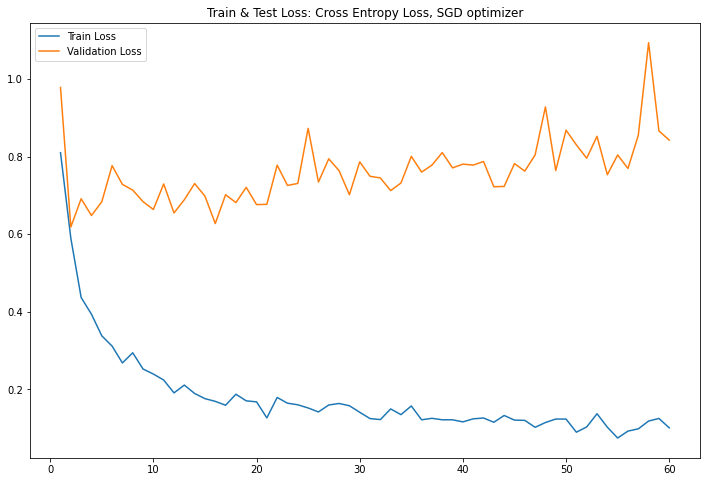

In [72]:
loss_plot(loss_train_list, loss_test_list, 'SGD optimizer')

##### Accuracy Plot:

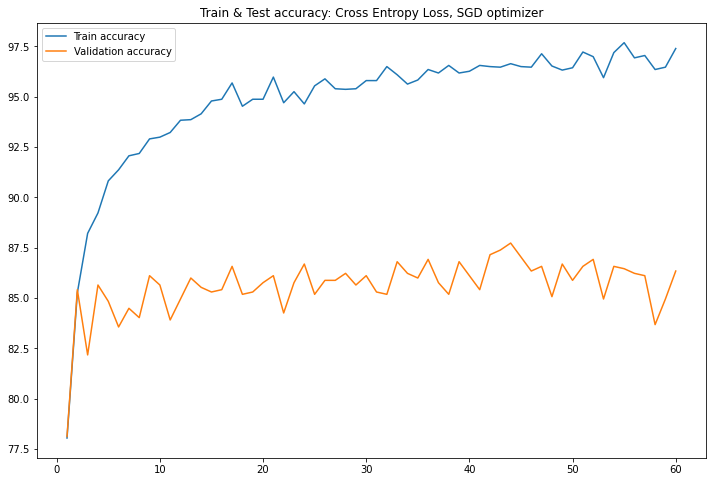

In [73]:
accuracy_plot(train_accuracy_list, test_accuracy_list, 'SGD optimizer')

#### Confusion matrix , Accuracy, loss, F1_score, Presicion of Test data:

In [111]:
lst_pred = [predictions_list[i].tolist() for i in range(len(predictions_list))]
lst_lbl = [labels_list[i].tolist() for i in range(len(labels_list))]
lst_pred = list(chain.from_iterable(lst_pred))
lst_lbl = list(chain.from_iterable(lst_lbl))

conf_matrix= confusion_matrix(lst_lbl, lst_pred)
print("Classification report:\n%s\n"
      % (metrics.classification_report(lst_lbl, lst_pred)))

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      9360
           1       0.85      0.89      0.87     12000
           2       0.84      0.83      0.84      9240
           3       0.87      0.87      0.87      9180
           4       0.85      0.86      0.85     12060

    accuracy                           0.86     51840
   macro avg       0.86      0.85      0.86     51840
weighted avg       0.86      0.86      0.86     51840




In [112]:
print(conf_matrix)

[[ 7623   933   141   381   282]
 [  497 10673   115   479   236]
 [  129    73  7703   133  1202]
 [  228   693   122  8007   130]
 [  283   209  1039   159 10370]]


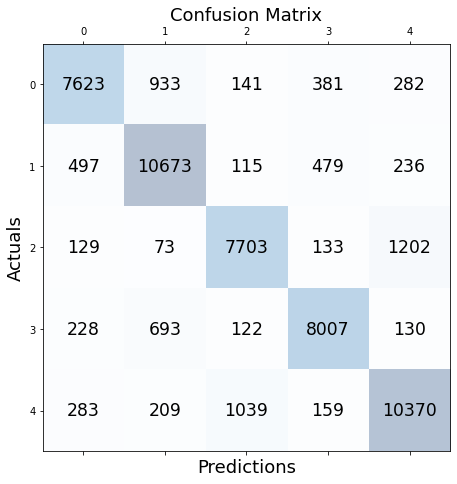

In [113]:
# Get the predictions
#
# y_pred = pipeline.predict(X_test)
#
# Calculate the confusion matrix
#
# conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [96]:

y_actual = []
y_pred = []
loss_test= []
with torch.no_grad():
    sum_of_loss= 0
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        #calculate outputs
        output = alex_net(images)
        _, predicted = torch.max(output.data, 1)
        
        curr_loss_test = loss_fn(output, labels)
        sum_of_loss += curr_loss_test.item()
          
                     
    
        
        for a, b in zip(labels, predicted):
            y_actual.append(a.item())
            y_pred.append(b.item())
            
loss_test.append((sum_of_loss_test/len(test_loader)))
    


# accuracy
print("accuracy:", accuracy_score(y_actual, y_pred))
# loss
print("loss:", loss_test[0])
# f1_score
print("f1_score:", f1_score(y_actual, y_pred, average="macro"))
# precision
print("presicion:", precision_score(y_actual, y_pred, average="macro"))


accuracy: 0.8634259259259259
loss: 0.8425293037837962
f1_score: 0.8622926308034959
presicion: 0.8650151376647411


##### Accuracy of each class:

In [81]:
# prepare to count predictions for each class
correct = {class_name: 0 for class_name in dataset.classes}
total = {class_name: 0 for class_name in dataset.classes}

# again no gradients needed
with torch.no_grad():
    for (inputs, labels) in test_loader:
        images, labels = inputs.to(device), labels.to(device)
        outputs = alex_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions of each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct[dataset.classes[label]] += 1
            total[dataset.classes[label]] += 1


# print accuracy of each class
for class_name, correct_count in correct.items():
    accuracy = (float(correct_count)*100) / total[class_name]
    print(f'Accuracy of {class_name}: {accuracy:.2f} %')

Accuracy of daisy: 83.33 %
Accuracy of dandelion: 89.50 %
Accuracy of rose: 81.82 %
Accuracy of sunflower: 86.93 %
Accuracy of tulip: 88.56 %


#### Predict Images:

In [106]:
def showimages(imgs,actual_lbls,pred_lbls=None):
   
  fig = plt.figure(figsize=(21,12))
 
  for i,img in enumerate(imgs):
     
    fig.add_subplot(2,5, i+1)
    y=actual_lbls[i]
     
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(dataset.classes[y_pre], dataset.classes[y])
    else: 
      title="Label: {0}".format(dataset.classes[y])
 
    plt.title(title, color=('green' if dataset.classes[y] == dataset.classes[y_pre] else 'red'))
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)
   
plt.show()

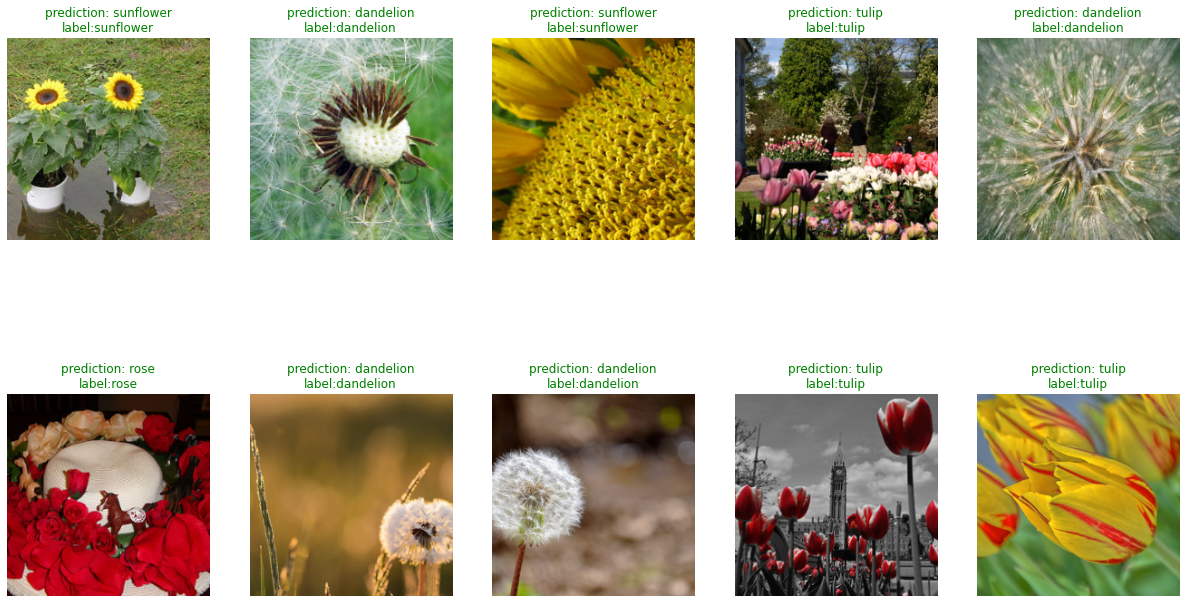

In [107]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images,actual_label,preds.cpu())
 
images, classes = next(iter(test_loader))
 
predict_images(alex_net, images, classes)


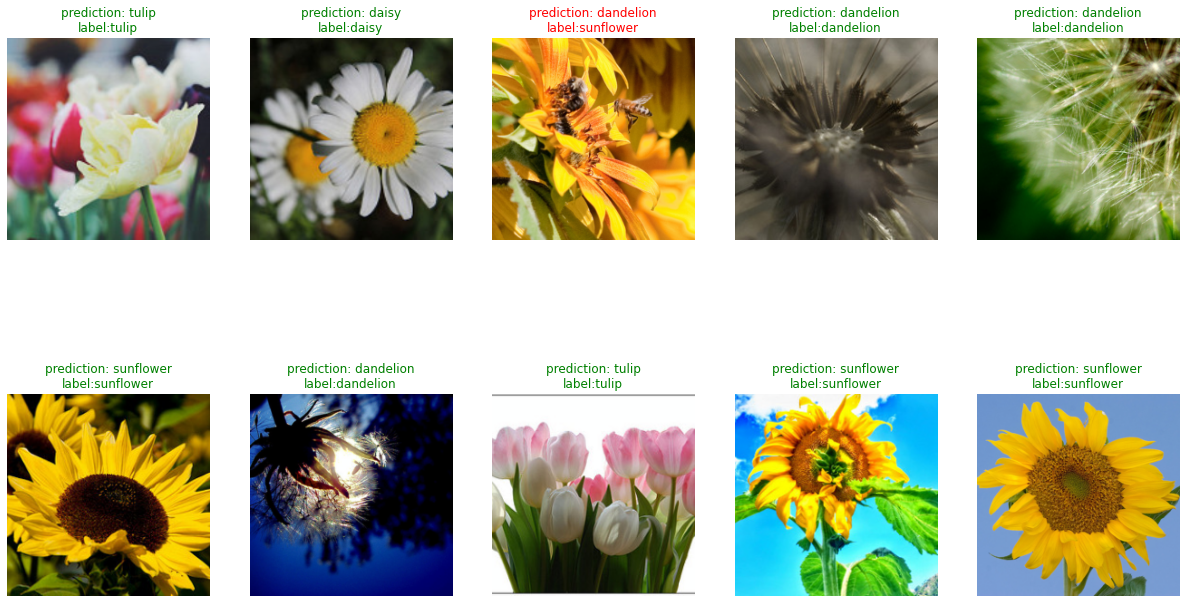

In [108]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images,actual_label,preds.cpu())
 
images, classes = next(iter(test_loader))
 
predict_images(alex_net, images, classes)
